In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Import a function to fit pushover curve with bilinear segments
from segmented_linear_regression import segmented_linear_regression

current_directory = os.getcwd()

base_directory = 'C:\\Users\\61946\\Documents\\GitHub\\SeismicDesignModule'


# Define Building IDs
ID1 = list(range(0, 81, 1))
ID2 = list(range(81, 566, 3))
ID3 = list(range(567, 1052, 3))
ID4 = [1053, 1056, 1059, 1062, 1065, 1068, 1071, 1074, 1080, 1083, 1086, 1089, 1092, 1095, 1098, 1101, 1104, 1107, 1110, 1113, 1116, 1119, 1122, 1125, 1128, 1134, 1137, 1140, 1143, 1146, 1149, 1152, 1155, 1158, 1161, 1164, 1167, 1170, 1173, 1176, 1188, 1191, 1194, 1197, 1200, 1203, 1206, 1209, 1212, 1215, 1218, 1221, 1224, 1227, 1242, 1245, 1248, 1251, 1254, 1257, 1260, 1263, 1266, 1269, 1272, 1275, 1278, 1281, 1284, 1296, 1299, 1302, 1305, 1308, 1311, 1314, 1317, 1320, 1323, 1326, 1329, 1332, 1335, 1338, 1350, 1353, 1356, 1359, 1362, 1365, 1368, 1371, 1374, 1377, 1380, 1383, 1404, 1407, 1410, 1413, 1416, 1419, 1422, 1425, 1428, 1431, 1434, 1437, 1458, 1461, 1464, 1467, 1470, 1473, 1476, 1479, 1482, 1485, 1488, 1491, 1512, 1515, 1518, 1521, 1524, 1527, 1530, 1533]
ID5 = [1539, 1542, 1566, 1569, 1572, 1575, 1578, 1581, 1584, 1587, 1590, 1593, 1596, 1599, 1620, 1623, 1626, 1629, 1632, 1635, 1638, 1641, 1644, 1647, 1650, 1653, 1674, 1677, 1680, 1683, 1686, 1689, 1692, 1695, 1701, 1704, 1707, 1728, 1731, 1734, 1737, 1740, 1743, 1746, 1749, 1755, 1758, 1761, 1782, 1785, 1788, 1791, 1794, 1797, 1800, 1803, 1809, 1812, 1815, 1836, 1839, 1842, 1845, 1848, 1851, 1863, 1866, 1890, 1893, 1896, 1899, 1902, 1905, 1917, 1920, 1944, 1947, 1950, 1953, 1956, 1959, 1971, 1998, 2001, 2004, 2007, 2010, 2013]

IDs = ID1 + ID2 + ID3 + ID4 + ID5;

## Extract pushover feature

In [2]:
yield_drift = list()
yield_force = list()
peak_drift = list()
peak_force = list()
two_percent_force = list()
two_percent_drift = list()
two_percent_area = list()
fitted_initial_stiffness = list()
fitted_hardening_stiffness = list()
fitted_hardening_ratio = list()


for indx in IDs:
    building_id = indx
    
    print('Current Building ID = ', building_id)
    
    if building_id not in [1083, 1086, 1575, 1677, 1692, 1839]:
        # Read building weight
        building_data_directory = base_directory + '\\BuildingData\\Building_' + str(building_id)
        os.chdir(building_data_directory)
        with open('Loads.csv', 'r') as file:
            load_info = pd.read_csv(file, header=0)
        building_weight = sum(load_info['floor weight'])

        # Read building pushover force
        pushover_directory = base_directory + '\\BuildingNonlinearModels\\Building_' + str(building_id) + '\\Pushoveranalysis' \
        + '\\PushoverOutput'
        os.chdir(pushover_directory + '\\BaseReactions')
        temp_force = np.loadtxt('XReactions.out')
        temp_reaction = np.sum(temp_force[:, 1:],axis=1)
        temp_normalized_reaction = temp_reaction / (building_weight/2) * (-1) # divided by two because there are two frames

        # Read building pushover drift
        os.chdir(pushover_directory + '\\StoryDrifts')
        temp_output = np.loadtxt('Roof.out')
        temp_drift = temp_output[:,-1]

        # Obtain final drift and force since some cases have convergence issue or negative force issue
        normalized_reaction = list()
        drift = list()
        for indx in range(0, len(temp_drift)):
            if temp_normalized_reaction[indx] <= 1.0 and temp_normalized_reaction[indx] >= 0.0 and temp_drift[indx] <= 0.04:
                normalized_reaction.append(temp_normalized_reaction[indx])
                drift.append(temp_drift[indx])

        # Store cleaned pushover curve into each building nonlinear model results
        os.chdir(pushover_directory)
        pushover_data = pd.DataFrame(data=np.column_stack([drift, normalized_reaction]), columns=['drift', 'normalized reaction'])
        pushover_data.to_csv('PushoverCurve.csv', sep=',', index=False)

        # Extract the peak drift and peak force
        peak_pos = np.argmax(normalized_reaction)
        peak_drift.append(drift[peak_pos])
        peak_force.append(normalized_reaction[peak_pos])

        # Extract the yielding drift and yielding force: define 85% of peak force as yielding point
        bilinear_drift = drift[0:peak_pos+1]
        bilinear_reaction = normalized_reaction[0:peak_pos+1]
        if building_id <= 1500:
            initial_breakpoints = [0.007]
        else:
            initial_breakpoints = [0.005]
        X_solution, Y_solution = segmented_linear_regression(bilinear_drift, bilinear_reaction, initial_breakpoints)
        yield_drift.append(X_solution[1])
        yield_force.append(Y_solution[1])

        # Extract the force which is associated with 2% drift
        difference = [each - 0.02 for each in drift]
        desired_pos = np.argmin(np.abs(difference))
        two_percent_drift.append(drift[desired_pos])
        two_percent_force.append(normalized_reaction[desired_pos])

        # Extract the area under the pushover curve from x = 0.0 to 0.02
        new_pushover_data = pushover_data[pushover_data['drift']<=0.02]
        area = np.trapz(new_pushover_data['normalized reaction'].values, new_pushover_data['drift'].values)
        two_percent_area.append(area)

        # Extract the fitted initial stiffness
        initial_stiffness = (Y_solution[1] - Y_solution[0]) / (X_solution[1] - X_solution[0])
        fitted_initial_stiffness.append(initial_stiffness)

        # Extract the fitted hardening stiffness
        hardening_stiffness = (Y_solution[2] - Y_solution[1]) / (X_solution[2] - X_solution[1])
        fitted_hardening_stiffness.append(hardening_stiffness)

        # Determine the hardening ratio
        fitted_hardening_ratio.append(hardening_stiffness/initial_stiffness)
    else:
        yield_drift.append('NA')
        yield_force.append('NA')
        peak_drift.append('NA')
        peak_force.append('NA')
        two_percent_force.append('NA')
        two_percent_drift.append('NA')
        two_percent_area.append('NA')
        fitted_initial_stiffness.append('NA')
        fitted_hardening_stiffness.append('NA')
        fitted_hardening_ratio.append('NA')

Current Building ID =  0
maximum iteration reached
Current Building ID =  1
maximum iteration reached
Current Building ID =  2
maximum iteration reached
Current Building ID =  3
Current Building ID =  4
Current Building ID =  5
maximum iteration reached
Current Building ID =  6
maximum iteration reached
Current Building ID =  7
maximum iteration reached
Current Building ID =  8
maximum iteration reached
Current Building ID =  9
maximum iteration reached
Current Building ID =  10
maximum iteration reached
Current Building ID =  11
maximum iteration reached
Current Building ID =  12
maximum iteration reached
Current Building ID =  13
maximum iteration reached
Current Building ID =  14
maximum iteration reached
Current Building ID =  15
Current Building ID =  16
maximum iteration reached
Current Building ID =  17
maximum iteration reached
Current Building ID =  18
maximum iteration reached
Current Building ID =  19
Current Building ID =  20
maximum iteration reached
Current Building ID = 

maximum iteration reached
Current Building ID =  402
maximum iteration reached
Current Building ID =  405
Current Building ID =  408
Current Building ID =  411
maximum iteration reached
Current Building ID =  414
maximum iteration reached
Current Building ID =  417
Current Building ID =  420
maximum iteration reached
Current Building ID =  423
maximum iteration reached
Current Building ID =  426
Current Building ID =  429
maximum iteration reached
Current Building ID =  432
Current Building ID =  435
maximum iteration reached
Current Building ID =  438
maximum iteration reached
Current Building ID =  441
maximum iteration reached
Current Building ID =  444
maximum iteration reached
Current Building ID =  447
Current Building ID =  450
Current Building ID =  453
Current Building ID =  456
maximum iteration reached
Current Building ID =  459
maximum iteration reached
Current Building ID =  462
Current Building ID =  465
maximum iteration reached
Current Building ID =  468
maximum iterati

maximum iteration reached
Current Building ID =  1014
Current Building ID =  1017
Current Building ID =  1020
Current Building ID =  1023
Current Building ID =  1026
Current Building ID =  1029
Current Building ID =  1032
maximum iteration reached
Current Building ID =  1035
Current Building ID =  1038
Current Building ID =  1041
maximum iteration reached
Current Building ID =  1044
Current Building ID =  1047
maximum iteration reached
Current Building ID =  1050
maximum iteration reached
Current Building ID =  1053
Current Building ID =  1056
Current Building ID =  1059
Current Building ID =  1062
maximum iteration reached
Current Building ID =  1065
Current Building ID =  1068
Current Building ID =  1071
Current Building ID =  1074
Current Building ID =  1080
Current Building ID =  1083
Current Building ID =  1086
Current Building ID =  1089
Current Building ID =  1092
Current Building ID =  1095
Current Building ID =  1098
Current Building ID =  1101
Current Building ID =  1104
Curr

In [3]:
os.chdir(base_directory)
data = np.column_stack([IDs, yield_drift, yield_force, \
                        peak_drift, peak_force, \
                        two_percent_drift, two_percent_force, two_percent_area, \
                        fitted_initial_stiffness, fitted_hardening_stiffness, fitted_hardening_ratio])
BuildingPushoverFeature = pd.DataFrame(data=data, columns=['Building ID', 'yield drift', 'yield force', 'peak drift', \
                                                           'peak force', '2% drift', '2% force', '2% area', 'fitted initial stiffness', \
                                                          'fitted hardening stiffness', 'fitted hardening ratio'])
BuildingPushoverFeature.to_csv('PushoverFeature.csv', sep=',', index=False)

## Process the extracted pushover features

In [1]:
import numpy as np
import pandas as pd
import os

# Before performing this procedure, manually replace those 'NA' values with buildings having closest features
# If the post-yielding stiffness ratio is greater than 5%, then take as 5%.
with open('PushoverFeature.csv', 'r') as file:
    BuildingPushoverFeature = pd.read_csv(file, header=0)


total_row = BuildingPushoverFeature.shape[0]
new_hardening_ratio = np.zeros([total_row, 1])
for indx in range(0, total_row):
    if BuildingPushoverFeature.loc[indx, 'fitted hardening ratio'] >= 0.05:
        new_hardening_ratio[indx, 0] = 0.05
    elif BuildingPushoverFeature.loc[indx, 'fitted hardening ratio'] >= 0.0:
        new_hardening_ratio[indx, 0] = BuildingPushoverFeature.loc[indx, 'fitted hardening ratio']
    else:
        new_hardening_ratio[indx, 0] = 0.0

BuildingPushoverFeature['hardening ratio'] = new_hardening_ratio

In [2]:
os.chdir('C:\\Users\\61946\\Documents\\GitHub\\SeismicDesignModule\\Postprocessing\\NonlinearModelGeneration')
BuildingPushoverFeature.to_csv('BuildingPushoverFeature.csv', index=False, sep=',')

## Testing with codes

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from segmented_linear_regression import segmented_linear_regression

base_directory = 'C:\\Users\\61946\\Documents\\GitHub\\SeismicDesignModule'

building_id = 1839

# Read building weight
building_data_directory = base_directory + '\\BuildingData\\Building_' + str(building_id)
os.chdir(building_data_directory)
with open('Loads.csv', 'r') as file:
    load_info = pd.read_csv(file, header=0)
building_weight = sum(load_info['floor weight'])

# Read building pushover force
pushover_directory = base_directory + '\\BuildingNonlinearModels\\Building_' + str(building_id) + '\\Pushoveranalysis' \
+ '\\PushoverOutput'
os.chdir(pushover_directory + '\\BaseReactions')
temp_force = np.loadtxt('XReactions.out')
temp_reaction = np.sum(temp_force[:, 1:],axis=1)
temp_normalized_reaction = temp_reaction / (building_weight/2) * (-1) # divided by two because there are two frames

# Read building pushover drift
os.chdir(pushover_directory + '\\StoryDrifts')
temp_output = np.loadtxt('Roof.out')
temp_drift = temp_output[:,-1]

# Obtain final drift and force since some cases have convergence issue or negative force issue
normalized_reaction = list()
drift = list()
for indx in range(0, len(temp_drift)):
    if temp_normalized_reaction[indx] <= 1.0 and temp_normalized_reaction[indx] >= 0.0 and temp_drift[indx] <= 0.04:
        normalized_reaction.append(temp_normalized_reaction[indx])
        drift.append(temp_drift[indx])

# Extract the peak drift and peak force
peak_pos = np.argmax(normalized_reaction)
# peak_drift.append(drift[peak_pos])
# peak_force.append(normalized_reaction[peak_pos])

# Obtain the pushover curve segment between initial point and peak point
bilinear_drift = drift[0:peak_pos+1]
bilinear_reaction = normalized_reaction[0:peak_pos+1]

# bilinear_drift.append(0.025)
# bilinear_reaction.append(normalized_reaction[peak_pos])

# bilinear_drift.append(0.035)
# bilinear_reaction.append(normalized_reaction[peak_pos])

# bilinear_drift.append(0.045)
# bilinear_reaction.append(normalized_reaction[peak_pos])

# bilinear_drift.append(0.055)
# bilinear_reaction.append(normalized_reaction[peak_pos])

maximum iteration reached
yield drift is  0.00856929276847828
yield force is  0.24966321352757218
peak drift is  0.00954808
peak force is  0.26169467700258403
initial stiffness is  29.12879384206446
0.4565573003156621


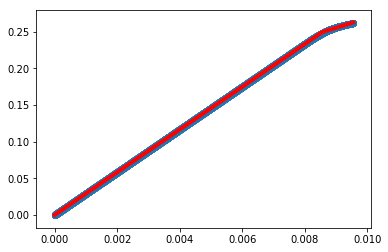

In [29]:
import matplotlib.pyplot as plt

initialBreakpoints = [0.006]
Xsolution, Ysolution = segmented_linear_regression(bilinear_drift, bilinear_reaction, initialBreakpoints)
plt.plot(Xsolution, Ysolution, '-r', linewidth=4)

plt.scatter(bilinear_drift, bilinear_reaction)

hardening = (Ysolution[2]-Ysolution[1])/(Xsolution[2]-Xsolution[1])
initial = (Ysolution[1]-Ysolution[0])/(Xsolution[1]-Xsolution[0])

print('yield drift is ', Xsolution[1])
print('yield force is ', Ysolution[1])
print('peak drift is ', drift[peak_pos])
print('peak force is ', normalized_reaction[peak_pos])
print('initial stiffness is ', initial)
print(hardening/initial)

## Extract exceptional cases

In [26]:
exceptID = list()

for indx in ID5:
    building_id = indx
    
    print('Current Building ID = ', building_id)
    
    # Read building weight
    building_data_directory = base_directory + '\\BuildingData\\Building_' + str(building_id)
    os.chdir(building_data_directory)
    with open('Loads.csv', 'r') as file:
        load_info = pd.read_csv(file, header=0)
    building_weight = sum(load_info['floor weight'])
    
    # Read building pushover force
    pushover_directory = base_directory + '\\BuildingNonlinearModels\\Building_' + str(building_id) + '\\Pushoveranalysis' \
    + '\\PushoverOutput'
    os.chdir(pushover_directory + '\\BaseReactions')
    temp_force = np.loadtxt('XReactions.out')
    temp_reaction = np.sum(temp_force[:, 1:],axis=1)
    temp_normalized_reaction = temp_reaction / (building_weight/2) * (-1) # divided by two because there are two frames
    
    # Read building pushover drift
    os.chdir(pushover_directory + '\\StoryDrifts')
    temp_output = np.loadtxt('Roof.out')
    temp_drift = temp_output[:,-1]
    
    # Find which building case has covergence issue
    for indx in range(0, len(temp_drift)):
        if abs(temp_normalized_reaction[indx]) > 1.0:
            if building_id not in exceptID:
                exceptID.append(building_id)

Current Building ID =  1539
Current Building ID =  1542
Current Building ID =  1566
Current Building ID =  1569
Current Building ID =  1572
Current Building ID =  1575
Current Building ID =  1578
Current Building ID =  1581
Current Building ID =  1584
Current Building ID =  1587
Current Building ID =  1590
Current Building ID =  1593
Current Building ID =  1596
Current Building ID =  1599
Current Building ID =  1620
Current Building ID =  1623
Current Building ID =  1626
Current Building ID =  1629
Current Building ID =  1632
Current Building ID =  1635
Current Building ID =  1638
Current Building ID =  1641
Current Building ID =  1644
Current Building ID =  1647
Current Building ID =  1650
Current Building ID =  1653
Current Building ID =  1674
Current Building ID =  1677
Current Building ID =  1680
Current Building ID =  1683
Current Building ID =  1686
Current Building ID =  1689
Current Building ID =  1692
Current Building ID =  1695
Current Building ID =  1701
Current Building ID 

Current Building ID =  1083


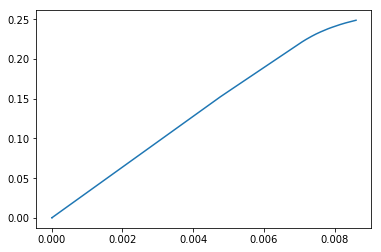

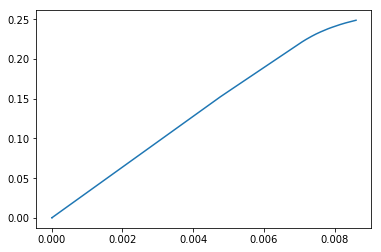

In [3]:
building_id = 1083

print('Current Building ID = ', building_id)

# Read building weight
building_data_directory = base_directory + '\\BuildingData\\Building_' + str(building_id)
os.chdir(building_data_directory)
with open('Loads.csv', 'r') as file:
    load_info = pd.read_csv(file, header=0)
building_weight = sum(load_info['floor weight'])

# Read building pushover force
pushover_directory = base_directory + '\\BuildingNonlinearModels\\Building_' + str(building_id) + '\\Pushoveranalysis' \
+ '\\PushoverOutput'
os.chdir(pushover_directory + '\\BaseReactions')
temp_force = np.loadtxt('XReactions.out')
temp_reaction = np.sum(temp_force[:, 1:],axis=1)
temp_normalized_reaction = temp_reaction / (building_weight/2) * (-1) # divided by two because there are two frames

# Read building pushover drift
os.chdir(pushover_directory + '\\StoryDrifts')
temp_output = np.loadtxt('Roof.out')
temp_drift = temp_output[:,-1]

# Obtain final drift and force since some cases have convergence issue or negative force issue
normalized_reaction = list()
drift = list()
for indx in range(0, len(temp_drift)):
    if temp_normalized_reaction[indx] <= 1.0 and temp_normalized_reaction[indx] >= 0.0 and temp_drift[indx] <= 0.04:
        normalized_reaction.append(temp_normalized_reaction[indx])
        drift.append(temp_drift[indx])

# Store cleaned pushover curve into each building nonlinear model results
os.chdir(pushover_directory)
pushover_data = pd.DataFrame(data=np.column_stack([drift, normalized_reaction]), columns=['drift', 'normalized reaction'])
# pushover_data.to_csv('PushoverCurve.csv', sep=',', index=False)

# Extract the peak drift and peak force
peak_pos = np.argmax(normalized_reaction)
# peak_drift.append(drift[peak_pos])
# peak_force.append(normalized_reaction[peak_pos])

# Extract the yielding drift and yielding force: define 85% of peak force as yielding point
bilinear_drift = drift[0:peak_pos+1]
bilinear_reaction = normalized_reaction[0:peak_pos+1]

plt.figure()
plt.plot(drift, normalized_reaction)

plt.figure()
plt.plot(bilinear_drift, bilinear_reaction)